In [1]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
from utils import *
from scipy.stats import zscore
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from loess import loess_1d
import matplotlib.patches as mpatches
from matplotlib import cm
from operator import * 

In [2]:
x = pd.read_csv('data/T47D.csv')

x.reset_index(drop=True, inplace=True)

metadata_well = x["Metadata_well"]
phase = x["phase"]

x0_phase = x["phase"][metadata_well == 0]
x1_phase = x["phase"][metadata_well == 1]
x10_phase = x["phase"][metadata_well == 10]
x100_phase = x["phase"][metadata_well == 100]
x1000_phase = x["phase"][metadata_well == 1000]

x = x.drop(["PHATE_1", "PHATE_2", "ploidy", "RB_status", "Metadata_well", "phate_labs", "Intensity_MedianIntensity_DNA", "cycD1_over_p21"], axis=1)
x = x.drop(["phase"], axis=1)

# normalize all data in a column 
x = x.apply(zscore)

# separate data according to treatment condition
x0 = x[metadata_well == 0]
x1 = x[metadata_well == 1]
x10 = x[metadata_well == 10]
x100 = x[metadata_well == 100]
x1000 = x[metadata_well == 1000]

x

,AreaShape_Area,Intensity_IntegratedIntensity_DNA,Intensity_MedianIntensity_CDK2,Intensity_MedianIntensity_CDK4,Intensity_MedianIntensity_CDK6,Intensity_MedianIntensity_Cdh1,Intensity_MedianIntensity_Cdt1,Intensity_MedianIntensity_E2F1,Intensity_MedianIntensity_ER,Intensity_MedianIntensity_Ki67,Intensity_MedianIntensity_PR,Intensity_MedianIntensity_RB,Intensity_MedianIntensity_Skp2,Intensity_MedianIntensity_cycA,Intensity_MedianIntensity_cycB1,Intensity_MedianIntensity_cycD1,Intensity_MedianIntensity_cycE,Intensity_MedianIntensity_p21,Intensity_MedianIntensity_pRB,pRB_over_RB
0,-0.926708,-0.458879,1.322612,0.976904,0.062764,0.145205,2.516578,0.407586,0.319061,0.171325,1.049717,1.051896,-0.311153,-0.521278,0.073700,0.668244,0.484200,0.070400,1.416008,1.096102
1,-1.245438,-0.453973,1.380743,1.118071,0.339295,0.705600,0.356098,-0.268247,1.292693,0.778215,0.357555,0.360486,0.389896,0.031649,0.344124,1.042431,0.511482,1.383663,-0.492447,-0.721884
2,-0.428693,-0.524069,-1.129765,-1.111307,-0.609492,-0.881059,-0.406767,-0.756349,-1.394264,-0.090779,-1.031554,-0.490300,-0.453394,-0.956203,-0.813080,-1.324588,-1.023143,-1.355428,-0.013936,0.536250
3,0.773184,1.365078,0.991996,-0.003277,-0.104108,0.536806,-0.377650,-0.503954,0.457196,3.020565,0.762645,1.222991,2.611576,3.787507,4.256493,-0.196356,0.247754,0.001129,2.124344,1.676043
4,-0.415413,-0.513221,0.339845,-0.884906,-0.804970,-0.016837,-0.170920,-0.630151,-0.713613,1.364434,-0.482928,0.812832,1.465175,-0.553308,-0.440808,-0.554952,-0.779877,-0.180707,0.845986,0.654180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64497,-1.411443,-1.082969,-0.837296,-0.987452,-0.249525,-0.168751,-0.245168,-0.550887,0.039448,-0.447140,-0.650387,-1.031710,-0.599023,-0.351017,0.161500,-1.130407,-0.547978,0.029992,-0.764185,-0.571897
64498,0.507576,1.177778,0.356194,-0.490703,0.224868,-0.185630,-0.415502,-0.416346,1.000826,-0.438872,3.030512,-0.895772,-0.541449,-0.554994,0.677764,-0.621569,0.497841,1.813721,-0.657306,-0.411726
64499,-0.561497,-0.439588,0.278081,2.664252,0.582451,0.286992,-0.127244,0.002921,0.651032,-0.495923,-0.063484,0.239782,-0.246805,0.328341,0.240520,2.310983,0.797945,0.211829,-0.588149,-0.812559
64500,-0.335730,-0.416980,-0.174246,-0.227014,-0.015904,0.070936,-0.581469,0.815381,-0.135449,-0.548013,-0.789138,-0.144595,-0.568543,-0.197614,-0.291548,-0.363606,0.343242,0.373461,-0.775362,-0.978463


In [3]:
# establish variables
trt_conditions: list[str] = ["", "0", "1", "10", "100", "1000"]

phases_dict = {'G0':'#5CAD92', 
               'G1':'#594997', 
               'G2/M':'#E7739A',
               'S':'#0099CC'}

features = [
    'Area',
    'DNA',
    'CDK2',
    'CDK4',
    'CDK6',
    'Cdh1',
    'Cdt1',
    'E2F1',
    'ER',
    'Ki67',
    'PR',
    'RB',
    'Skp2',
    'cycA',
    'cycB1',
    'cycD1',
    'cycE',
    'p21',
    'pRB',
    'pRB_over_RB',
]

In [4]:
x0_phase = x0_phase.to_numpy()
x1_phase = x1_phase.to_numpy()
x10_phase = x10_phase.to_numpy()
x100_phase = x100_phase.to_numpy()
x1000_phase = x1000_phase.to_numpy()

In [5]:
# assign colors according to phase 
x0_phase_colors = []
x1_phase_colors = []
x10_phase_colors = []
x100_phase_colors = []
x1000_phase_colors = []

for i in range(len(x0_phase)): 
    x0_phase_colors.append(phases_dict[x0_phase[i]])

for i in range(len(x1_phase)): 
    x1_phase_colors.append(phases_dict[x1_phase[i]])

for i in range(len(x10_phase)): 
    x10_phase_colors.append(phases_dict[x10_phase[i]])

for i in range(len(x100_phase)): 
    x100_phase_colors.append(phases_dict[x100_phase[i]])

for i in range(len(x1000_phase)): 
    x1000_phase_colors.append(phases_dict[x1000_phase[i]])

In [6]:
# calculate percentage of cells in each phase
g0_0 = countOf(x0_phase, "G0")/len(x0_phase)
g1_0 = countOf(x0_phase, "G1")/len(x0_phase)
s_0 = countOf(x0_phase, "S")/len(x0_phase)
g2m_0 = countOf(x0_phase, "G2/M")/len(x0_phase)

g0_1 = countOf(x1_phase, "G0")/len(x1_phase)
g1_1 = countOf(x1_phase, "G1")/len(x1_phase)
s_1 = countOf(x1_phase, "S")/len(x1_phase)
g2m_1 = countOf(x1_phase, "G2/M")/len(x1_phase)

g0_10 = countOf(x10_phase, "G0")/len(x10_phase)
g1_10 = countOf(x10_phase, "G1")/len(x10_phase)
s_10 = countOf(x10_phase, "S")/len(x10_phase)
g2m_10 = countOf(x10_phase, "G2/M")/len(x10_phase)

g0_100 = countOf(x100_phase, "G0")/len(x100_phase)
g1_100 = countOf(x100_phase, "G1")/len(x100_phase)
s_100 = countOf(x100_phase, "S")/len(x100_phase)
g2m_100 = countOf(x100_phase, "G2/M")/len(x100_phase)

g0_1000 = countOf(x1000_phase, "G0")/len(x1000_phase)
g1_1000 = countOf(x1000_phase, "G1")/len(x1000_phase)
s_1000 = countOf(x1000_phase, "S")/len(x1000_phase)
g2m_1000 = countOf(x1000_phase, "G2/M")/len(x1000_phase)

## Perform SPCA 

In [7]:
# global hypersphere 
c,r,V = Spherelets(x, 2)

# individual hyperspheres per treatment condition 
x0_c, x0_r, x0_V = Spherelets(x0, 2)
x1_c, x1_r, x1_V = Spherelets(x1, 2)
x10_c, x10_r, x10_V = Spherelets(x10, 2)
x100_c, x100_r, x100_V = Spherelets(x100, 2)
x1000_c, x1000_r, x1000_V = Spherelets(x1000, 2)

# calculate projections for each treatment condition onto global hypersphere
x0_proj = Proj(x0, x0_r, x0_c, V)
x1_proj = Proj(x1, x1_r, x1_c, V)
x10_proj = Proj(x10, x10_r, x10_c, V)
x100_proj = Proj(x100, x100_r, x100_c, V)
x1000_proj = Proj(x1000, x1000_r, x1000_c, V)

In [8]:
x0_proj = x0_proj.to_numpy()
x1_proj = x1_proj.to_numpy()
x10_proj = x10_proj.to_numpy()
x100_proj = x100_proj.to_numpy()
x1000_proj = x1000_proj.to_numpy()

### Center Values

In [9]:
# center values 
for i in range(len(features)): 
    vars()[f'{features[i]}'] = [x0_c[i][0], x1_c[i][0], x10_c[i][0], x100_c[i][0], x1000_c[i][0]]

centers = pd.DataFrame(list(zip(trt_conditions[1:], Area, DNA, CDK2, CDK4, CDK6, Cdh1, Cdt1, E2F1, ER, Ki67, PR, RB, Skp2, cycA, cycB1, cycD1, cycE, p21, pRB, pRB_over_RB)), columns=['Treatment'] + features)
centers

,Treatment,Area,DNA,CDK2,CDK4,CDK6,Cdh1,Cdt1,E2F1,ER,...,PR,RB,Skp2,cycA,cycB1,cycD1,cycE,p21,pRB,pRB_over_RB
0,0,0.192010,0.611243,0.987563,0.189204,0.763804,0.817071,0.498587,0.281201,0.865892,...,0.773186,0.713495,1.175513,1.264695,1.228059,0.021703,0.508103,0.659121,0.920029,0.742549
1,1,0.212745,0.665796,1.235818,0.360159,0.718182,0.986268,0.357225,0.212534,0.955274,...,0.795150,0.614663,1.085402,1.112358,1.239972,-0.027345,0.589505,0.730759,0.926646,0.829770
2,10,0.240318,0.643368,0.735622,0.634487,0.827152,0.748580,0.461076,0.415317,1.088923,...,0.445305,0.735673,0.861689,0.852243,0.858630,0.251087,0.797607,0.582681,0.759939,0.547068
3,100,0.864397,0.685463,-0.100131,-0.060646,0.189312,0.680248,-0.030615,0.111137,0.311924,...,0.035551,0.088377,-0.089978,0.132530,0.137471,0.592928,-0.083950,0.387386,-0.161672,-0.208083
4,1000,0.832362,0.790094,0.548639,0.565456,0.758763,0.084539,-0.250730,-0.238277,0.602360,...,0.268908,-0.443810,-0.181147,0.100128,0.316402,0.653404,0.530754,0.496522,-0.556512,-0.491351


In [10]:
centers.to_csv("data/center_features.csv", index=False)

### Center Shifts from Untreated Condition

In [11]:
for i in range(len(features)): 
    vars()[f'{features[i]}'] = [x1_c[i][0]-x0_c[i][0], x10_c[i][0]-x0_c[i][0], x100_c[i][0]-x0_c[i][0], x1000_c[i][0]-x0_c[i][0]]

center_shifts = pd.DataFrame(list(zip(trt_conditions[2:], Area, DNA, CDK2, CDK4, CDK6, Cdh1, Cdt1, E2F1, ER, Ki67, PR, RB, Skp2, cycA, cycB1, cycD1, cycE, p21, pRB, pRB_over_RB)), columns=['Treatment'] + features)
center_shifts

,Treatment,Area,DNA,CDK2,CDK4,CDK6,Cdh1,Cdt1,E2F1,ER,...,PR,RB,Skp2,cycA,cycB1,cycD1,cycE,p21,pRB,pRB_over_RB
0,1,0.020735,0.054554,0.248255,0.170955,-0.045622,0.169197,-0.141362,-0.068667,0.089382,...,0.021964,-0.098832,-0.090110,-0.152337,0.011913,-0.049048,0.081402,0.071638,0.006617,0.087221
1,10,0.048308,0.032126,-0.251941,0.445282,0.063347,-0.068491,-0.037510,0.134116,0.223031,...,-0.327881,0.022178,-0.313823,-0.412452,-0.369429,0.229385,0.289505,-0.076440,-0.160089,-0.195481
2,100,0.672387,0.074220,-1.087694,-0.249851,-0.574493,-0.136823,-0.529202,-0.170064,-0.553968,...,-0.737635,-0.625118,-1.265491,-1.132165,-1.090589,0.571225,-0.592052,-0.271735,-1.081700,-0.950632
3,1000,0.640353,0.178852,-0.438924,0.376251,-0.005041,-0.732532,-0.749317,-0.519477,-0.263533,...,-0.504278,-1.157305,-1.356660,-1.164567,-0.911657,0.631701,0.022651,-0.162599,-1.476540,-1.233900


In [12]:
center_shifts.to_csv("data/center_shifts.csv", index=False)

In [13]:
# reduce digits for plot 
x1_x0_c = []
x10_x0_c = []
x100_x0_c = []
x1000_x0_c = []
x10000_x0_c = []

for i in range(len(x0_c)): 
    x1_x0_c.append(round(x1_c[i][0]-x0_c[i][0], 2))
    x10_x0_c.append(round(x10_c[i][0]-x0_c[i][0], 2))
    x100_x0_c.append(round(x100_c[i][0]-x0_c[i][0], 2))
    x1000_x0_c.append(round(x1000_c[i][0]-x0_c[i][0], 2))


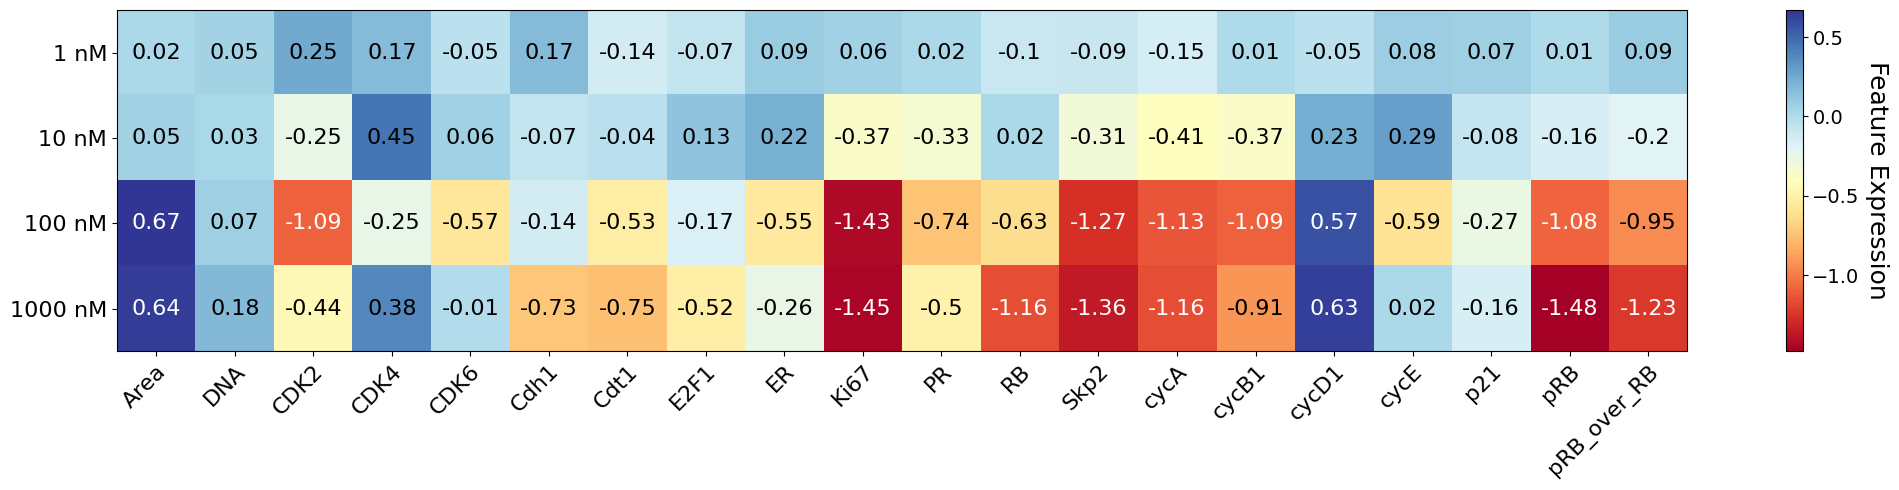

In [14]:
center_shifts_arr = np.array([
    x1_x0_c,
    x10_x0_c, 
    x100_x0_c,
    x1000_x0_c,
    ])

fig, ax = plt.subplots(figsize=(21,5))
im = ax.imshow(center_shifts_arr, aspect='auto', cmap="RdYlBu")

ax.set_xticks(np.arange(len(features)), labels=features, fontsize="16")
ax.set_yticks(np.arange(len(trt_conditions[2:])), labels=[f'{trt_conditions[i]} nM' for i in range(2,len(trt_conditions))], fontsize="16")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(trt_conditions[2:])):
    for j in range(len(features)):
        # text = ax.text(j, i, center_shifts_arr[i, j],
        #                 ha="center", va="center", color="black", fontsize="12")
        if center_shifts_arr[i, j] > 0.5 or center_shifts_arr[i, j] < -1: 
            text = ax.text(j, i, center_shifts_arr[i, j],
                        ha="center", va="center", color="w", fontsize="16")
        else: 
            text = ax.text(j, i, center_shifts_arr[i, j],
                        ha="center", va="center", color="black", fontsize="16")
        
# Add colorbar 
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Feature Expression', rotation=-90, va="bottom", fontsize="18")

fig.tight_layout()

plt.show()

In [15]:
reordered_features = [
    'Ki67',
    'pRB',
    'Skp2',
    'pRB_over_RB',
    'cycA', 
    'cycB1',
    'RB',
    'CDK2',
    'PR',
    'Cdh1',
    'E2F1',
    'Cdt1',
    'ER',
    'CDK6',
    'p21',
    'cycE',
    'DNA',
    'CDK4',
    'Area', 
    'cycD1',
]

reordered_center_shifts = pd.DataFrame(list(zip(trt_conditions[2:], Ki67, pRB, Skp2, pRB_over_RB, cycA, cycB1, RB, CDK2, PR, Cdh1, E2F1, Cdt1, ER, CDK6, p21, cycE, DNA, CDK4, Area, cycD1)), columns=['Treatment'] + reordered_features)

In [16]:
# establish key for center values 
x0_c_key = {}
x1_c_key = {}
x10_c_key = {}
x100_c_key = {}
x1000_c_key = {}

for i in range(1,len(trt_conditions)):
    for j in range(len(features)): 
        vars()[f'x{trt_conditions[i]}_c_key'][features[j]] = vars()[f'x{trt_conditions[i]}_c'][j][0]

x1_x0_c_re = []
x10_x0_c_re = []
x100_x0_c_re = []
x1000_x0_c_re = []
x10000_x0_c_re = []

for i in range(len(reordered_features)): 
    x1_x0_c_re.append(round(x1_c_key[reordered_features[i]]-x0_c_key[reordered_features[i]], 2))
    x10_x0_c_re.append(round(x10_c_key[reordered_features[i]]-x0_c_key[reordered_features[i]], 2))
    x100_x0_c_re.append(round(x100_c_key[reordered_features[i]]-x0_c_key[reordered_features[i]], 2))
    x1000_x0_c_re.append(round(x1000_c_key[reordered_features[i]]-x0_c_key[reordered_features[i]], 2))

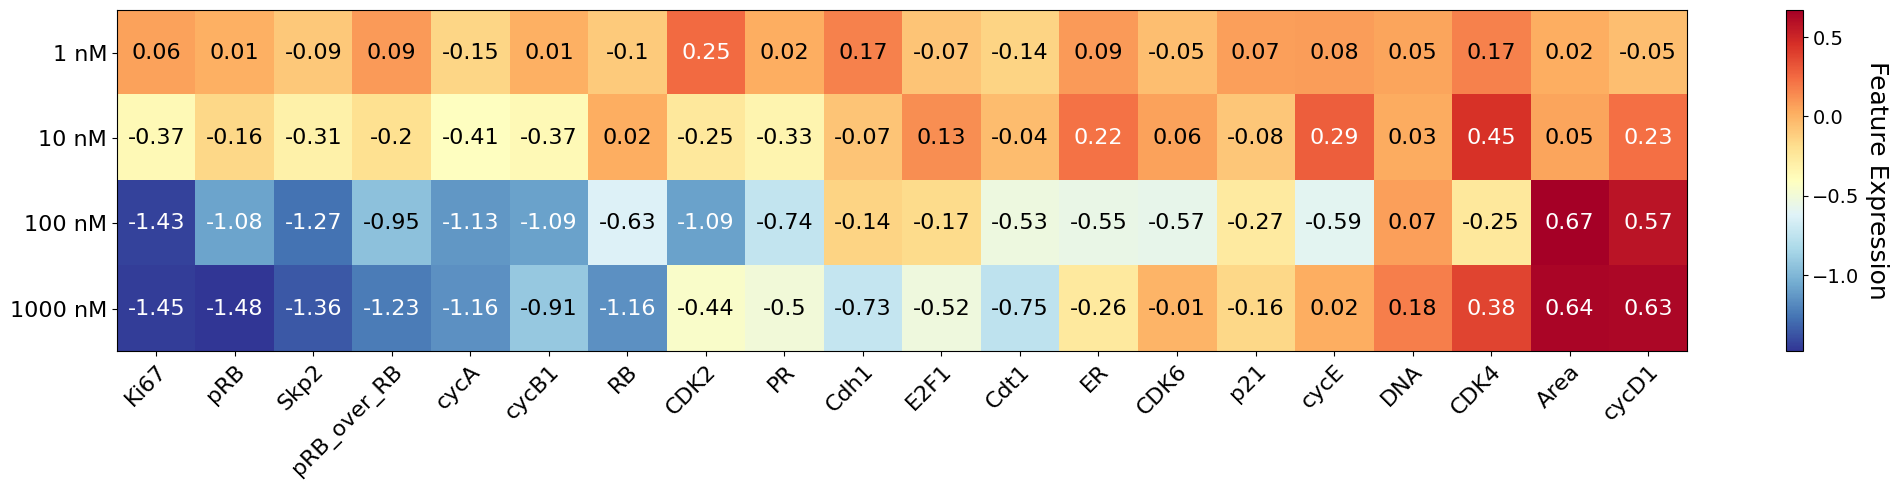

<Figure size 640x480 with 0 Axes>

In [17]:
center_shifts_arr_re = np.array([
    x1_x0_c_re,
    x10_x0_c_re, 
    x100_x0_c_re,
    x1000_x0_c_re,
    ])

fig, ax = plt.subplots(figsize=(21,5))
im = ax.imshow(center_shifts_arr_re, aspect='auto', cmap="RdYlBu_r")

ax.set_xticks(np.arange(len(reordered_features)), labels=reordered_features, fontsize="16")
ax.set_yticks(np.arange(len(trt_conditions[2:])), labels=[f'{trt_conditions[i]} nM' for i in range(2,len(trt_conditions))], fontsize="16")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(trt_conditions[2:])):
    for j in range(len(reordered_features)):
        # text = ax.text(j, i, center_shifts_arr[i, j],
        #                 ha="center", va="center", color="black", fontsize="12")
        if center_shifts_arr_re[i, j] > 0.2 or center_shifts_arr_re[i, j] < -1.05: 
            text = ax.text(j, i, center_shifts_arr_re[i, j],
                        ha="center", va="center", color="w", fontsize="16")
        else: 
            text = ax.text(j, i, center_shifts_arr_re[i, j],
                        ha="center", va="center", color="black", fontsize="16")
        
# Add colorbar 
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Feature Expression', rotation=-90, va="bottom", fontsize="18")

fig.tight_layout()

plt.show()

plt.savefig(f"figures/center_shifts.pdf", format="pdf", bbox_inches="tight")


In [18]:
# calculate centers projected to 3D V

# initialize vars for 3d center coords 
for i in range(1, len(trt_conditions)): 
    vars()[f"x_x{trt_conditions[i]}"] = 0
    vars()[f"y_x{trt_conditions[i]}"] = 0
    vars()[f"z_x{trt_conditions[i]}"] = 0

# project centers to V 
for i in range(1, len(trt_conditions)):
    x_c = vars()[f"x{trt_conditions[i]}_c"]
    x_r = vars()[f"x{trt_conditions[i]}_r"]
    vars()[f"x{trt_conditions[i]}_c_proj"] = Proj(x_c, x_r, x_c, V) # V b/c global V 

    # find average x, y, z coords across all features 
    for j in range(len(features)): 
        vars()[f"x_x{trt_conditions[i]}"] += vars()[f"x{trt_conditions[i]}_c_proj"][j][0]
        vars()[f"y_x{trt_conditions[i]}"] += vars()[f"x{trt_conditions[i]}_c_proj"][j][1]
        vars()[f"z_x{trt_conditions[i]}"] += vars()[f"x{trt_conditions[i]}_c_proj"][j][2]
    vars()[f"x_x{trt_conditions[i]}"] /= len(features)
    vars()[f"y_x{trt_conditions[i]}"] /= len(features)
    vars()[f"z_x{trt_conditions[i]}"] /= len(features)

# 3d centers
x0_c_proj_3d = [x_x0, y_x0, z_x0]
x1_c_proj_3d = [x_x1, y_x1, z_x1]
x10_c_proj_3d = [x_x10, y_x10, z_x10]
x100_c_proj_3d = [x_x100, y_x100, z_x100]
x1000_c_proj_3d = [x_x1000, y_x1000, z_x1000]

In [19]:
# add centers to projections 

# intialize vars for updated 3d coords 
for i in range(1, len(trt_conditions)): 
    vars()[f'x_x{trt_conditions[i]}_c'] = []
    vars()[f'y_x{trt_conditions[i]}_c'] = []
    vars()[f'z_x{trt_conditions[i]}_c'] = []

# add 3d centers to prev 3d projection coords 
for i in range(1, len(trt_conditions)): 
    proj = vars()[f'x{trt_conditions[i]}_proj']
    for j in range(len(proj)):
        vars()[f'x_x{trt_conditions[i]}_c'].append(proj[j][0] + vars()[f'x_x{trt_conditions[i]}'])
        vars()[f'y_x{trt_conditions[i]}_c'].append(proj[j][1] + vars()[f'y_x{trt_conditions[i]}'])
        vars()[f'z_x{trt_conditions[i]}_c'].append(proj[j][2] + vars()[f'z_x{trt_conditions[i]}'])

x['SPCA_1'] = x_x0_c + x_x1_c + x_x10_c + x_x100_c + x_x1000_c 
x['SPCA_2'] = y_x0_c + y_x1_c + y_x10_c + y_x100_c + y_x1000_c 
x['SPCA_3'] = z_x0_c + z_x1_c + z_x10_c + z_x100_c + z_x1000_c 
x['metadata_well'] = metadata_well
x['phase'] = phase

x

,AreaShape_Area,Intensity_IntegratedIntensity_DNA,Intensity_MedianIntensity_CDK2,Intensity_MedianIntensity_CDK4,Intensity_MedianIntensity_CDK6,Intensity_MedianIntensity_Cdh1,Intensity_MedianIntensity_Cdt1,Intensity_MedianIntensity_E2F1,Intensity_MedianIntensity_ER,Intensity_MedianIntensity_Ki67,...,Intensity_MedianIntensity_cycD1,Intensity_MedianIntensity_cycE,Intensity_MedianIntensity_p21,Intensity_MedianIntensity_pRB,pRB_over_RB,SPCA_1,SPCA_2,SPCA_3,metadata_well,phase
0,-0.926708,-0.458879,1.322612,0.976904,0.062764,0.145205,2.516578,0.407586,0.319061,0.171325,...,0.668244,0.484200,0.070400,1.416008,1.096102,2.906165,3.041375,-4.858270,0,G1
1,-1.245438,-0.453973,1.380743,1.118071,0.339295,0.705600,0.356098,-0.268247,1.292693,0.778215,...,1.042431,0.511482,1.383663,-0.492447,-0.721884,3.250569,5.739280,-2.719712,0,G0
2,-0.428693,-0.524069,-1.129765,-1.111307,-0.609492,-0.881059,-0.406767,-0.756349,-1.394264,-0.090779,...,-1.324588,-1.023143,-1.355428,-0.013936,0.536250,5.182868,1.268170,-1.132286,0,G0
3,0.773184,1.365078,0.991996,-0.003277,-0.104108,0.536806,-0.377650,-0.503954,0.457196,3.020565,...,-0.196356,0.247754,0.001129,2.124344,1.676043,-1.733553,-0.391441,1.042538,0,G2/M
4,-0.415413,-0.513221,0.339845,-0.884906,-0.804970,-0.016837,-0.170920,-0.630151,-0.713613,1.364434,...,-0.554952,-0.779877,-0.180707,0.845986,0.654180,4.769931,0.378697,-1.672874,0,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64497,-1.411443,-1.082969,-0.837296,-0.987452,-0.249525,-0.168751,-0.245168,-0.550887,0.039448,-0.447140,...,-1.130407,-0.547978,0.029992,-0.764185,-0.571897,2.203839,-3.484884,-2.644479,1000,G0
64498,0.507576,1.177778,0.356194,-0.490703,0.224868,-0.185630,-0.415502,-0.416346,1.000826,-0.438872,...,-0.621569,0.497841,1.813721,-0.657306,-0.411726,-0.258259,0.711035,0.473657,1000,G0
64499,-0.561497,-0.439588,0.278081,2.664252,0.582451,0.286992,-0.127244,0.002921,0.651032,-0.495923,...,2.310983,0.797945,0.211829,-0.588149,-0.812559,-0.542553,-0.520119,-4.287978,1000,G0
64500,-0.335730,-0.416980,-0.174246,-0.227014,-0.015904,0.070936,-0.581469,0.815381,-0.135449,-0.548013,...,-0.363606,0.343242,0.373461,-0.775362,-0.978463,1.989056,-3.280287,-3.180554,1000,G0


In [20]:
x.to_csv("data/T47D_SPCA.csv", index=False)

## Plot Hyperspheres

In [21]:
# colors for treatment conditions 
viridis = cm.get_cmap('viridis', 12)
trt_colors = viridis(np.linspace(0, 1, 5))
trt_colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.220057, 0.343307, 0.549413, 1.      ],
       [0.119512, 0.607464, 0.540218, 1.      ],
       [0.525776, 0.833491, 0.288127, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

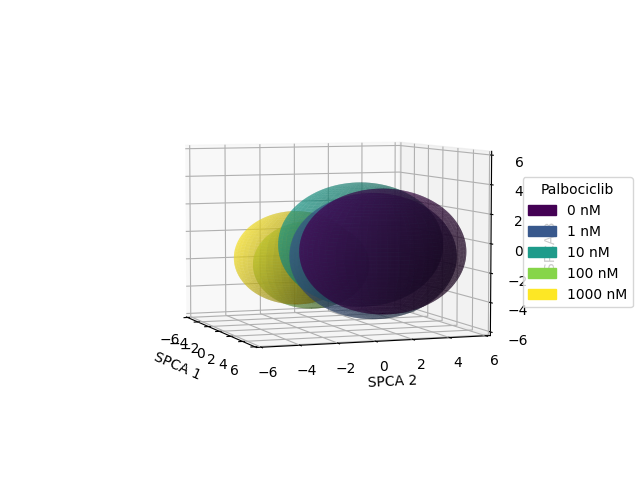

In [22]:
# all treatment conditions
%matplotlib widget

# Define the center and radius values for 2 spheres
centers = np.array([x0_c_proj_3d, x1_c_proj_3d, x10_c_proj_3d, x100_c_proj_3d, x1000_c_proj_3d])
radii = np.array([x0_r, x1_r, x10_r, x100_r, x1000_r])

# Create a 3D scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the spheres
for i, (center, radius) in enumerate(zip(centers, radii)):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    xi = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    yi = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    zi = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(xi, yi, zi, color=trt_colors[i], alpha=0.5)

    # Generate random points around each sphere
    num_points = 50
    phi = np.random.uniform(0, 2 * np.pi, num_points)
    theta = np.random.uniform(0, np.pi, num_points)
    r = np.random.uniform(0, radius, num_points)

# Set axis labels
ax.set_xlabel('SPCA 1')
ax.set_ylabel('SPCA 2')
ax.set_zlabel('SPCA 3')

plt.xlim(-6, 6)
plt.ylim(-6, 6)
ax.set_zlim(-6, 6)

# Add a legend
color_0 = mpatches.Patch(color=trt_colors[0], label='0 nM')
color_1 = mpatches.Patch(color=trt_colors[1], label='1 nM')
color_10 = mpatches.Patch(color=trt_colors[2], label='10 nM')
color_100 = mpatches.Patch(color=trt_colors[3], label='100 nM')
color_1000 = mpatches.Patch(color=trt_colors[4], label='1000 nM')
ax.legend(bbox_to_anchor=(1.4, 0.5),
            loc="right",
            borderaxespad=2.,
            title="Palbociclib",
            handles=[color_0, color_1, color_10, color_100, color_1000])

ax.view_init(5,340)


# Show the plot
plt.show()

# plt.savefig("fig3a_spca_legend.pdf", format="pdf", bbox_inches="tight")


## Plot Projections

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

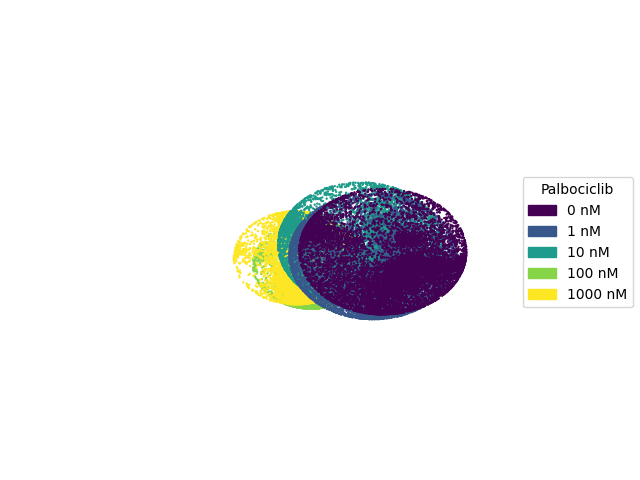

In [23]:
%matplotlib widget

# Create a 3D scatterplot
fig = plt.figure()
ax=fig.add_subplot(111,projection='3d')

for i in range(1, len(trt_conditions)): 
    ax.scatter3D(x['SPCA_1'][metadata_well == int(trt_conditions[i])], 
                x['SPCA_2'][metadata_well == int(trt_conditions[i])], 
                x['SPCA_3'][metadata_well == int(trt_conditions[i])], 
                alpha=1, 
                c=trt_colors[i-1], 
                s=0.5)

plt.xlim(-6, 6)
plt.ylim(-6, 6)
ax.set_zlim(-6, 6)

# Add a legend
color_0 = mpatches.Patch(color=trt_colors[0], label='0 nM')
color_1 = mpatches.Patch(color=trt_colors[1], label='1 nM')
color_10 = mpatches.Patch(color=trt_colors[2], label='10 nM')
color_100 = mpatches.Patch(color=trt_colors[3], label='100 nM')
color_1000 = mpatches.Patch(color=trt_colors[4], label='1000 nM')
ax.legend(bbox_to_anchor=(1.4, 0.5),
            loc="right",
            borderaxespad=2.,
            title="Palbociclib",
            handles=[color_0, color_1, color_10, color_100, color_1000])

ax.view_init(5,340)

plt.grid(False)
plt.axis('off')

# Show the plot
plt.show()

plt.savefig("figures/spca_proj.pdf", format="pdf", bbox_inches="tight")

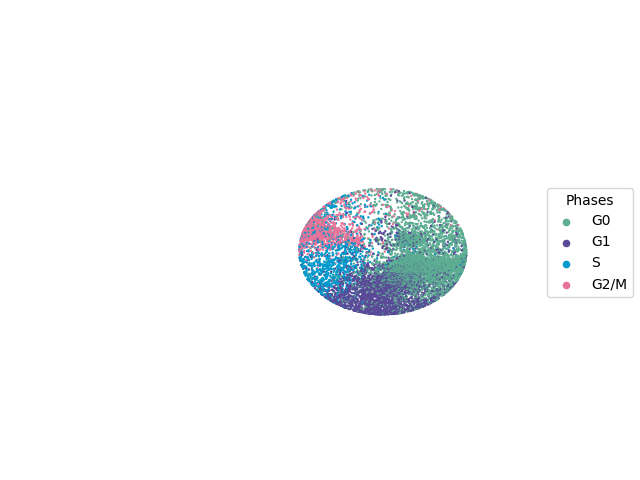

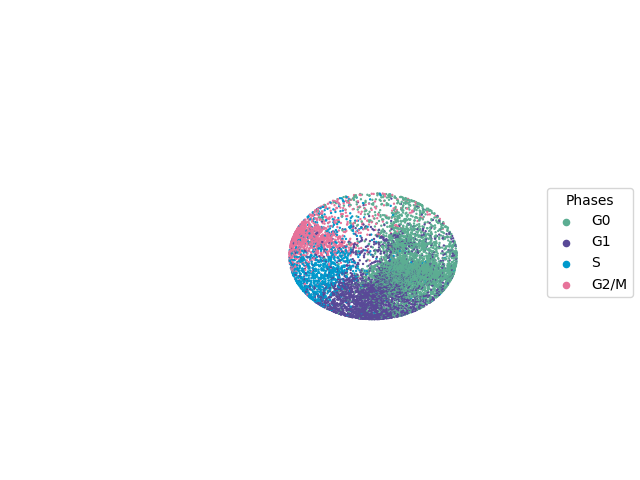

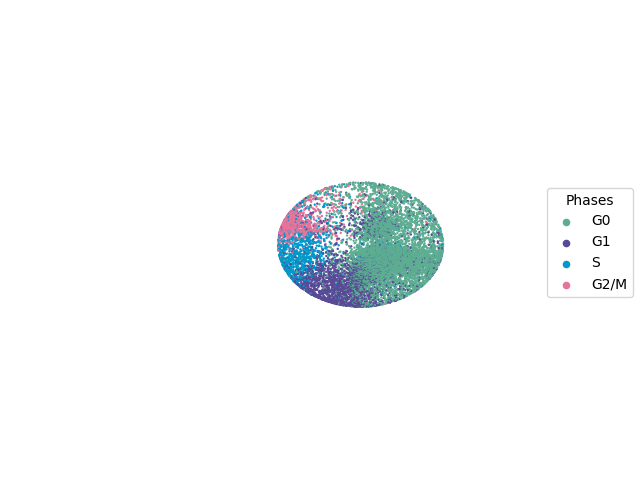

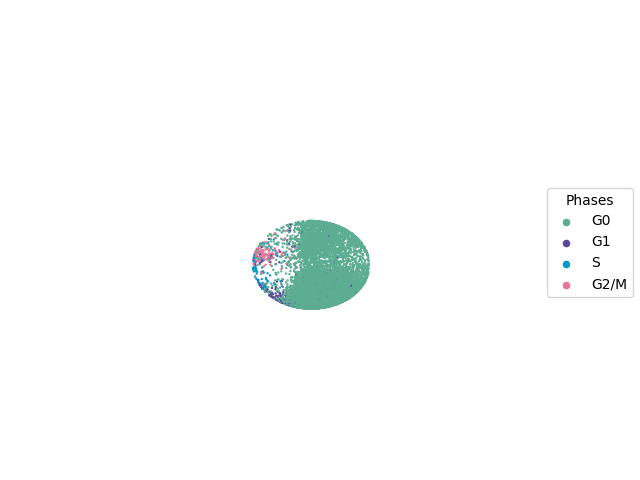

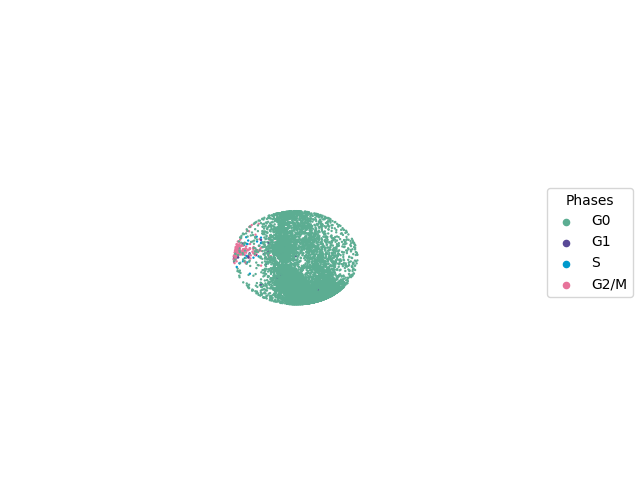

In [24]:
%matplotlib widget

for i in range(1, len(trt_conditions)):
    # Create a 3D scatterplot
    fig = plt.figure()
    ax=fig.add_subplot(111,projection='3d')

    phase_colors = vars()[f"x{trt_conditions[i]}_phase_colors"]
    phases = vars()[f"x{trt_conditions[i]}_phase"]

    ax.scatter3D(x['SPCA_1'][metadata_well == int(trt_conditions[i])], 
                 x['SPCA_2'][metadata_well == int(trt_conditions[i])], 
                 x['SPCA_3'][metadata_well == int(trt_conditions[i])], 
                 alpha=1, 
                 c=phase_colors, 
                 s=0.5)
    

    ax.set_xlabel('SPCA 1')
    ax.set_ylabel('SPCA 2')
    ax.set_zlabel('SPCA 3')

    plt.grid(False)
    plt.axis('off')
    
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    ax.set_zlim(-6, 6)

    plt.scatter([], [], c='#5CAD92', s=20, label="G0")
    plt.scatter([], [], c='#594997', s=20, label="G1")
    plt.scatter([], [], c='#0099CC', s=20, label="S")
    plt.scatter([], [], c='#E7739A', s=20, label="G2/M")
    plt.legend(bbox_to_anchor=(1.4, 0.5),
            loc="right",
            borderaxespad=2.,
            scatterpoints=1, 
            title="Phases")
    
    ax.view_init(5,340)

    plt.show()

    plt.savefig(f"figures/phases_{trt_conditions[i]}.pdf", format="pdf", bbox_inches="tight")
    

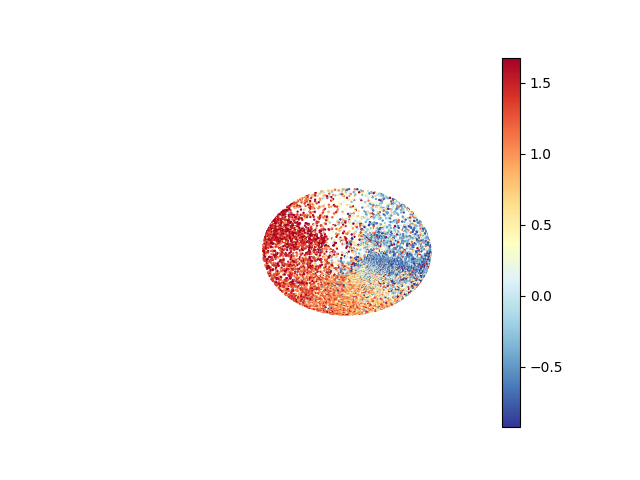

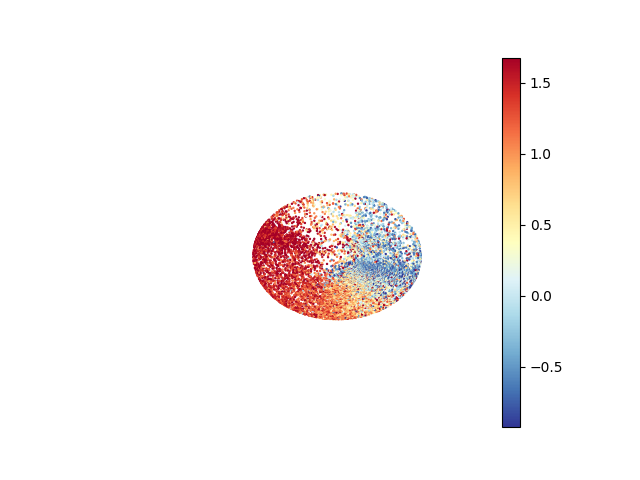

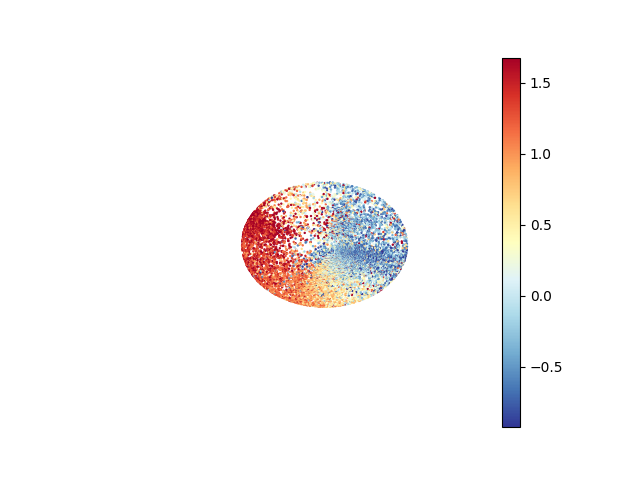

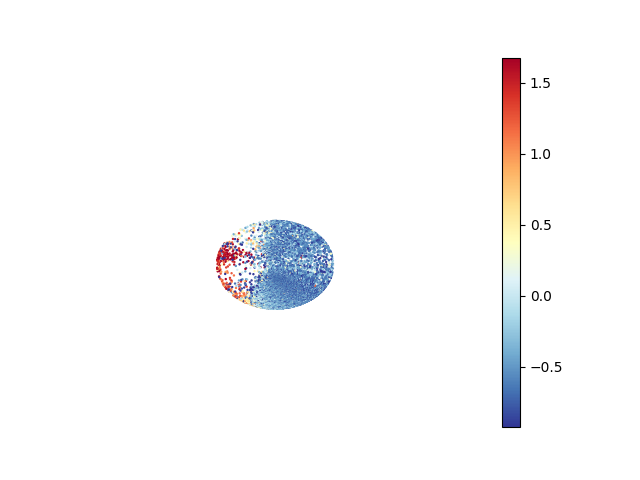

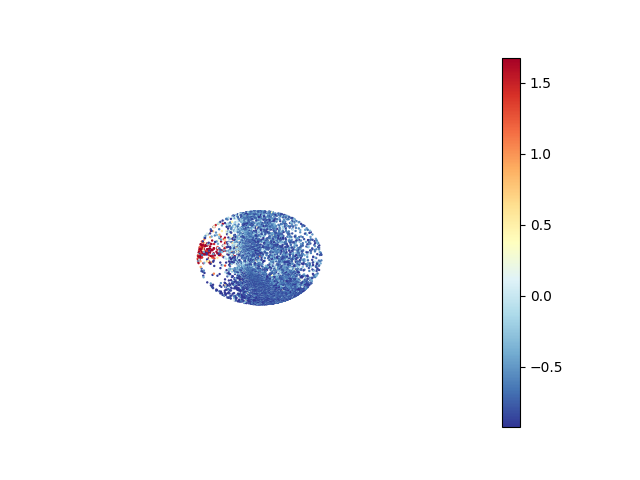

In [25]:
%matplotlib widget

feature = 'pRB_over_RB'

for i in range(1,len(trt_conditions)):
    fig = plt.figure()
    ax=fig.add_subplot(111,projection='3d')

    feature_exp = vars()[f'x{trt_conditions[i]}'][feature].to_numpy()
    total_feature = x[feature].to_numpy()

    sc = ax.scatter3D(x['SPCA_1'][metadata_well == int(trt_conditions[i])], 
                    x['SPCA_2'][metadata_well == int(trt_conditions[i])], 
                    x['SPCA_3'][metadata_well == int(trt_conditions[i])], 
                    alpha=1, 
                    c=feature_exp, 
                    vmin=np.percentile(total_feature, 5),
                    vmax=np.percentile(total_feature, 95),
                    cmap='RdYlBu_r',
                    s=0.5)

    # Set axis labels
    ax.set_xlabel('SPCA 1')
    ax.set_ylabel('SPCA 2')
    ax.set_zlabel('SPCA 3')

    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    ax.set_zlim(-6, 6)

    ax.view_init(5,340)

    plt.grid(False)
    plt.axis('off')
    
    # Add colorbar 
    plt.colorbar(sc)

    # Show the plot
    plt.show()
    
    plt.savefig(f"figures/feature_exp/{feature}_{trt_conditions[i]}.pdf", format="pdf", bbox_inches="tight")
        

## G0 Cells 

In [26]:
g0_0 = x[x['metadata_well'] == 0]
g0_0 = g0_0[g0_0['phase'] == 'G0']

g0_1 = x[x['metadata_well'] == 1]
g0_1 = g0_1[g0_1['phase'] == 'G0']

g0_10 = x[x['metadata_well'] == 10]
g0_10 = g0_10[g0_10['phase'] == 'G0']

g0_100 = x[x['metadata_well'] == 100]
g0_100 = g0_100[g0_100['phase'] == 'G0']

g0_1000 = x[x['metadata_well'] == 1000]
g0_1000 = g0_1000[g0_1000['phase'] == 'G0']

In [27]:
cols = g0_0.columns

for i in range(len(features)): 
    vars()[f'{features[i]}_g0'] = [
        round(g0_0[cols[i]].mean(), 2),
        round(g0_1[cols[i]].mean(), 2),
        round(g0_10[cols[i]].mean(), 2),
        round(g0_100[cols[i]].mean(), 2),
        round(g0_1000[cols[i]].mean(), 2),
        ]

In [28]:
reordered_g0 = pd.DataFrame(list(zip(trt_conditions[1:], Ki67_g0, pRB_g0, pRB_over_RB_g0, Skp2_g0, cycA_g0, cycB1_g0, RB_g0, CDK2_g0, Cdt1_g0, PR_g0, Cdh1_g0, E2F1_g0, ER_g0, cycE_g0, CDK6_g0, p21_g0, DNA_g0, CDK4_g0, Area_g0, cycD1_g0)), columns=['Treatment'] + reordered_features)
reordered_g0_arr = reordered_g0.drop(['Treatment'],axis=1).to_numpy()

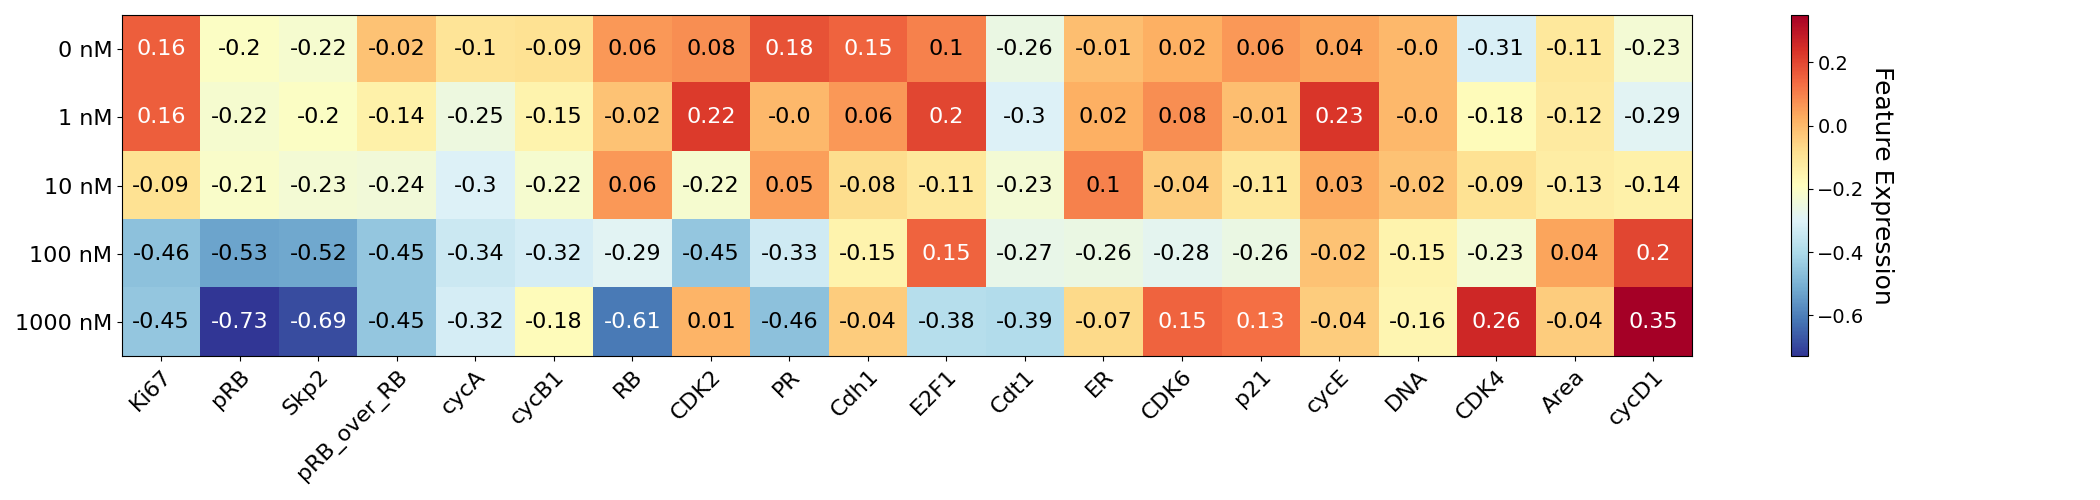

In [29]:
fig, ax = plt.subplots(figsize=(21,5))
im = ax.imshow(reordered_g0_arr, aspect='auto', cmap="RdYlBu_r")

ax.set_xticks(np.arange(len(reordered_features)), labels=reordered_features, fontsize="16")
ax.set_yticks(np.arange(len(trt_conditions[1:])), labels=[f'{trt_conditions[i]} nM' for i in range(1,len(trt_conditions))], fontsize="16")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(trt_conditions)-1):
    for j in range(len(reordered_features)):
        if reordered_g0_arr[i, j] > 0.1 or reordered_g0_arr[i, j] < -0.6: 
            text = ax.text(j, i, reordered_g0_arr[i, j],
                        ha="center", va="center", color="w", fontsize="16")
        else: 
            text = ax.text(j, i, reordered_g0_arr[i, j],
                        ha="center", va="center", color="black", fontsize="16")
        
# Add colorbar 
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Feature Expression', rotation=-90, va="bottom", fontsize="18")

fig.tight_layout()

plt.show()

plt.savefig(f"figures/g0.pdf", format="pdf", bbox_inches="tight")

## Feature Means

In [30]:
for i in range(len(features)): 
    vars()[f'{features[i]}_mean'] = [
        round(x1[cols[i]].mean()-x0[cols[i]].mean(), 2), 
        round(x10[cols[i]].mean()-x0[cols[i]].mean(), 2), 
        round(x100[cols[i]].mean()-x0[cols[i]].mean(), 2), 
        round(x1000[cols[i]].mean()-x0[cols[i]].mean(), 2), 
        ]

In [31]:
reordered_mean = pd.DataFrame(list(zip(trt_conditions[2:], Ki67_mean, pRB_mean, pRB_over_RB_mean, Skp2_mean, cycA_mean, cycB1_mean, RB_mean, CDK2_mean, Cdt1_mean, PR_mean, Cdh1_mean, E2F1_mean, ER_mean, cycE_mean, CDK6_mean, p21_mean, DNA_mean, CDK4_mean, Area_mean, cycD1_mean)), columns=['Treatment'] + reordered_features)
reordered_mean_arr = reordered_mean.drop(['Treatment'],axis=1).to_numpy()

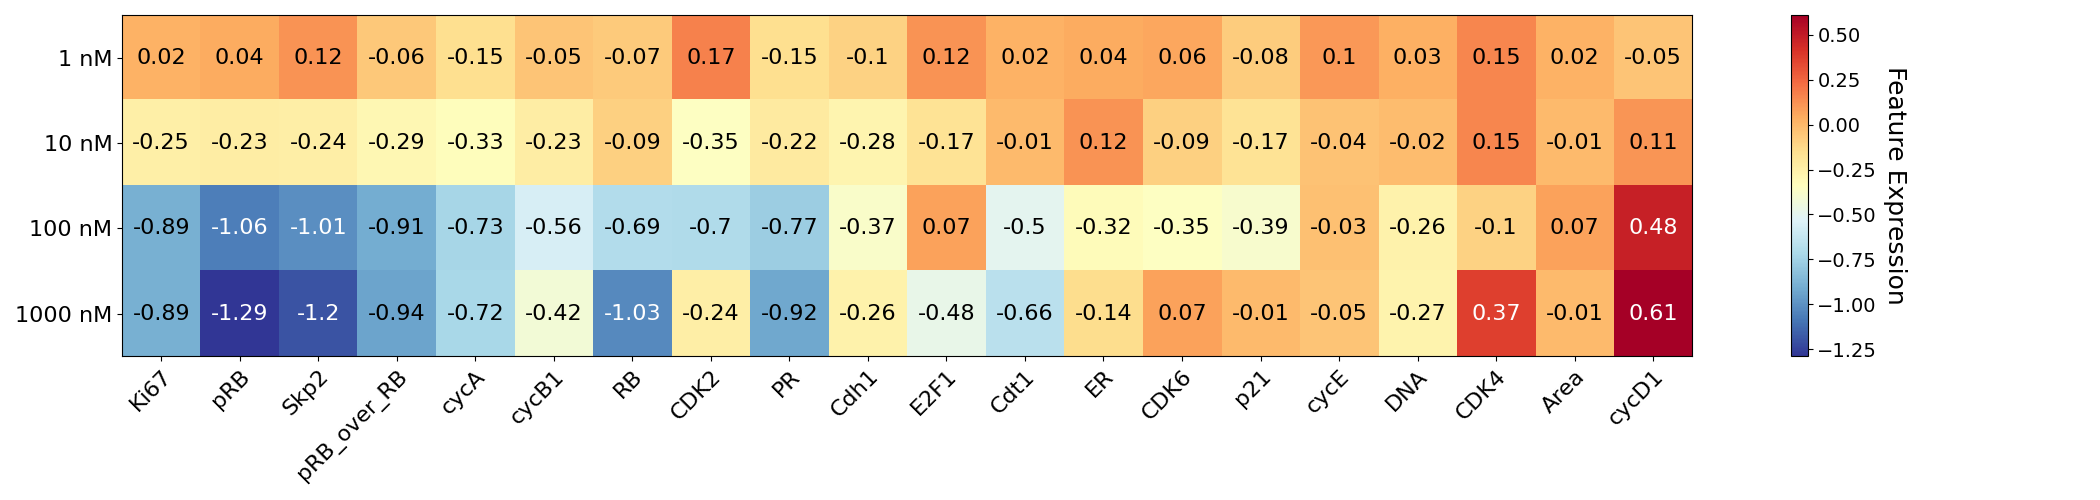

In [34]:
fig, ax = plt.subplots(figsize=(21,5))
im = ax.imshow(reordered_mean_arr, aspect='auto', cmap="RdYlBu_r")

ax.set_xticks(np.arange(len(reordered_features)), labels=reordered_features, fontsize="16")
ax.set_yticks(np.arange(len(trt_conditions[2:])), labels=[f'{trt_conditions[i]} nM' for i in range(2,len(trt_conditions))], fontsize="16")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(trt_conditions)-2):
    for j in range(len(reordered_features)):
        if reordered_mean_arr[i, j] > 0.25 or reordered_mean_arr[i, j] < -0.95: 
            text = ax.text(j, i, reordered_mean_arr[i, j],
                        ha="center", va="center", color="w", fontsize="16")
        else: 
            text = ax.text(j, i, reordered_mean_arr[i, j],
                        ha="center", va="center", color="black", fontsize="16")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Feature Expression', rotation=-90, va="bottom", fontsize="18")

fig.tight_layout()

plt.show()

plt.savefig(f"figures/feature_mean_shifts.pdf", format="pdf", bbox_inches="tight")

In [40]:
# violin plots 
# for i in range(len(features)):
#     for j in range(1, len(trt_conditions)): 
#         fig, ax = plt.subplots()
#         ax.violinplot(vars()[f'x{trt_conditions[j]}'][cols[i]], showextrema=True, showmeans=True, showmedians=True)
#         ax.set_title(f'{trt_conditions[j]}: {features[i]}')
#         plt.savefig(f'figures/feature_means/{trt_conditions[j]}_{features[i]}.pdf', format="pdf", bbox_inches="tight")

## Perform PCA 

In [36]:
x

,AreaShape_Area,Intensity_IntegratedIntensity_DNA,Intensity_MedianIntensity_CDK2,Intensity_MedianIntensity_CDK4,Intensity_MedianIntensity_CDK6,Intensity_MedianIntensity_Cdh1,Intensity_MedianIntensity_Cdt1,Intensity_MedianIntensity_E2F1,Intensity_MedianIntensity_ER,Intensity_MedianIntensity_Ki67,...,Intensity_MedianIntensity_cycD1,Intensity_MedianIntensity_cycE,Intensity_MedianIntensity_p21,Intensity_MedianIntensity_pRB,pRB_over_RB,SPCA_1,SPCA_2,SPCA_3,metadata_well,phase
0,-0.926708,-0.458879,1.322612,0.976904,0.062764,0.145205,2.516578,0.407586,0.319061,0.171325,...,0.668244,0.484200,0.070400,1.416008,1.096102,2.906165,3.041375,-4.858270,0,G1
1,-1.245438,-0.453973,1.380743,1.118071,0.339295,0.705600,0.356098,-0.268247,1.292693,0.778215,...,1.042431,0.511482,1.383663,-0.492447,-0.721884,3.250569,5.739280,-2.719712,0,G0
2,-0.428693,-0.524069,-1.129765,-1.111307,-0.609492,-0.881059,-0.406767,-0.756349,-1.394264,-0.090779,...,-1.324588,-1.023143,-1.355428,-0.013936,0.536250,5.182868,1.268170,-1.132286,0,G0
3,0.773184,1.365078,0.991996,-0.003277,-0.104108,0.536806,-0.377650,-0.503954,0.457196,3.020565,...,-0.196356,0.247754,0.001129,2.124344,1.676043,-1.733553,-0.391441,1.042538,0,G2/M
4,-0.415413,-0.513221,0.339845,-0.884906,-0.804970,-0.016837,-0.170920,-0.630151,-0.713613,1.364434,...,-0.554952,-0.779877,-0.180707,0.845986,0.654180,4.769931,0.378697,-1.672874,0,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64497,-1.411443,-1.082969,-0.837296,-0.987452,-0.249525,-0.168751,-0.245168,-0.550887,0.039448,-0.447140,...,-1.130407,-0.547978,0.029992,-0.764185,-0.571897,2.203839,-3.484884,-2.644479,1000,G0
64498,0.507576,1.177778,0.356194,-0.490703,0.224868,-0.185630,-0.415502,-0.416346,1.000826,-0.438872,...,-0.621569,0.497841,1.813721,-0.657306,-0.411726,-0.258259,0.711035,0.473657,1000,G0
64499,-0.561497,-0.439588,0.278081,2.664252,0.582451,0.286992,-0.127244,0.002921,0.651032,-0.495923,...,2.310983,0.797945,0.211829,-0.588149,-0.812559,-0.542553,-0.520119,-4.287978,1000,G0
64500,-0.335730,-0.416980,-0.174246,-0.227014,-0.015904,0.070936,-0.581469,0.815381,-0.135449,-0.548013,...,-0.363606,0.343242,0.373461,-0.775362,-0.978463,1.989056,-3.280287,-3.180554,1000,G0


In [37]:
pca = PCA(n_components=3)
x_principalComponents = pca.fit_transform(x.drop(['metadata_well', 'phase'], axis=1))
x_pca_coords = pd.DataFrame(data=x_principalComponents, columns = ['PCA_1', 'PCA_2', 'PCA_3'])

In [38]:
x_pca = x.copy()
x_pca['PCA_1'] = x_pca_coords['PCA_1']
x_pca['PCA_2'] = x_pca_coords['PCA_2']
x_pca['PCA_3'] = x_pca_coords['PCA_3']
x_pca['metadata_well'] = metadata_well
x_pca['phase'] = phase
x_pca

,AreaShape_Area,Intensity_IntegratedIntensity_DNA,Intensity_MedianIntensity_CDK2,Intensity_MedianIntensity_CDK4,Intensity_MedianIntensity_CDK6,Intensity_MedianIntensity_Cdh1,Intensity_MedianIntensity_Cdt1,Intensity_MedianIntensity_E2F1,Intensity_MedianIntensity_ER,Intensity_MedianIntensity_Ki67,...,Intensity_MedianIntensity_pRB,pRB_over_RB,SPCA_1,SPCA_2,SPCA_3,metadata_well,phase,PCA_1,PCA_2,PCA_3
0,-0.926708,-0.458879,1.322612,0.976904,0.062764,0.145205,2.516578,0.407586,0.319061,0.171325,...,1.416008,1.096102,2.906165,3.041375,-4.858270,0,G1,1.896881,3.289461,-3.608641
1,-1.245438,-0.453973,1.380743,1.118071,0.339295,0.705600,0.356098,-0.268247,1.292693,0.778215,...,-0.492447,-0.721884,3.250569,5.739280,-2.719712,0,G0,2.637100,5.781750,-1.769029
2,-0.428693,-0.524069,-1.129765,-1.111307,-0.609492,-0.881059,-0.406767,-0.756349,-1.394264,-0.090779,...,-0.013936,0.536250,5.182868,1.268170,-1.132286,0,G0,-3.666300,2.280991,1.480426
3,0.773184,1.365078,0.991996,-0.003277,-0.104108,0.536806,-0.377650,-0.503954,0.457196,3.020565,...,2.124344,1.676043,-1.733553,-0.391441,1.042538,0,G2/M,6.922645,-2.806180,3.986356
4,-0.415413,-0.513221,0.339845,-0.884906,-0.804970,-0.016837,-0.170920,-0.630151,-0.713613,1.364434,...,0.845986,0.654180,4.769931,0.378697,-1.672874,0,G1,-1.270141,1.317400,0.914042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64497,-1.411443,-1.082969,-0.837296,-0.987452,-0.249525,-0.168751,-0.245168,-0.550887,0.039448,-0.447140,...,-0.764185,-0.571897,2.203839,-3.484884,-2.644479,1000,G0,-2.539031,-2.888859,-0.804070
64498,0.507576,1.177778,0.356194,-0.490703,0.224868,-0.185630,-0.415502,-0.416346,1.000826,-0.438872,...,-0.657306,-0.411726,-0.258259,0.711035,0.473657,1000,G0,2.510198,0.128645,1.766733
64499,-0.561497,-0.439588,0.278081,2.664252,0.582451,0.286992,-0.127244,0.002921,0.651032,-0.495923,...,-0.588149,-0.812559,-0.542553,-0.520119,-4.287978,1000,G0,2.164848,-1.550878,-3.603040
64500,-0.335730,-0.416980,-0.174246,-0.227014,-0.015904,0.070936,-0.581469,0.815381,-0.135449,-0.548013,...,-0.775362,-0.978463,1.989056,-3.280287,-3.180554,1000,G0,-1.541076,-2.855271,-1.360941


In [40]:
x_pca.to_csv('data/T47D_PCA.csv', index=False)

## Perform PHATE

In [41]:
import phate
phate_op = phate.PHATE(n_components = 4, n_jobs = -1, knn = 200, t=12) 
phate_fit = phate_op.fit_transform(x.drop(['metadata_well', 'phase'], axis=1))

Calculating PHATE...
  Running PHATE on 64502 observations and 23 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 87.33 seconds.
    Calculating affinities...
    Calculated affinities in 8.25 seconds.
  Calculated graph and diffusion operator in 97.86 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 66.48 seconds.
    Calculating KMeans...
    Calculated KMeans in 10.02 seconds.
  Calculated landmark operator in 81.17 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.49 seconds.
  Calculating metric MDS...


/usr/local/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 57.07 seconds.
Calculated PHATE in 236.62 seconds.


In [42]:
x_phate = x.copy()
x_phate["PHATE_1"] =  phate_fit[:,0]
x_phate["PHATE_2"] =  phate_fit[:,1]
x_phate["PHATE_3"] =  phate_fit[:,2]
x_phate

,AreaShape_Area,Intensity_IntegratedIntensity_DNA,Intensity_MedianIntensity_CDK2,Intensity_MedianIntensity_CDK4,Intensity_MedianIntensity_CDK6,Intensity_MedianIntensity_Cdh1,Intensity_MedianIntensity_Cdt1,Intensity_MedianIntensity_E2F1,Intensity_MedianIntensity_ER,Intensity_MedianIntensity_Ki67,...,Intensity_MedianIntensity_pRB,pRB_over_RB,SPCA_1,SPCA_2,SPCA_3,metadata_well,phase,PHATE_1,PHATE_2,PHATE_3
0,-0.926708,-0.458879,1.322612,0.976904,0.062764,0.145205,2.516578,0.407586,0.319061,0.171325,...,1.416008,1.096102,2.906165,3.041375,-4.858270,0,G1,-0.016598,-0.003072,-0.005484
1,-1.245438,-0.453973,1.380743,1.118071,0.339295,0.705600,0.356098,-0.268247,1.292693,0.778215,...,-0.492447,-0.721884,3.250569,5.739280,-2.719712,0,G0,-0.016742,-0.003753,-0.004812
2,-0.428693,-0.524069,-1.129765,-1.111307,-0.609492,-0.881059,-0.406767,-0.756349,-1.394264,-0.090779,...,-0.013936,0.536250,5.182868,1.268170,-1.132286,0,G0,-0.023771,0.012080,-0.000583
3,0.773184,1.365078,0.991996,-0.003277,-0.104108,0.536806,-0.377650,-0.503954,0.457196,3.020565,...,2.124344,1.676043,-1.733553,-0.391441,1.042538,0,G2/M,-0.007292,-0.009238,0.011178
4,-0.415413,-0.513221,0.339845,-0.884906,-0.804970,-0.016837,-0.170920,-0.630151,-0.713613,1.364434,...,0.845986,0.654180,4.769931,0.378697,-1.672874,0,G1,-0.018366,0.004423,-0.003062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64497,-1.411443,-1.082969,-0.837296,-0.987452,-0.249525,-0.168751,-0.245168,-0.550887,0.039448,-0.447140,...,-0.764185,-0.571897,2.203839,-3.484884,-2.644479,1000,G0,0.025129,0.005440,0.003746
64498,0.507576,1.177778,0.356194,-0.490703,0.224868,-0.185630,-0.415502,-0.416346,1.000826,-0.438872,...,-0.657306,-0.411726,-0.258259,0.711035,0.473657,1000,G0,0.010497,-0.009155,0.001737
64499,-0.561497,-0.439588,0.278081,2.664252,0.582451,0.286992,-0.127244,0.002921,0.651032,-0.495923,...,-0.588149,-0.812559,-0.542553,-0.520119,-4.287978,1000,G0,0.012969,-0.008084,-0.005551
64500,-0.335730,-0.416980,-0.174246,-0.227014,-0.015904,0.070936,-0.581469,0.815381,-0.135449,-0.548013,...,-0.775362,-0.978463,1.989056,-3.280287,-3.180554,1000,G0,0.022703,0.001288,0.000707


In [44]:
x_phate.to_csv("data/T47D_PHATE.csv", index=False)